In [1]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx

In [2]:
G = nx.Graph()
G.add_node('A')
G.add_node('B')
G.add_node('C')
G.add_node('D')
G.add_edge('A', 'B')
G.add_edge('B', 'C')
G.add_edge('A', 'C')
G.add_edge('C', 'D')

In [3]:
G.number_of_nodes(), G.number_of_edges()

(4, 4)

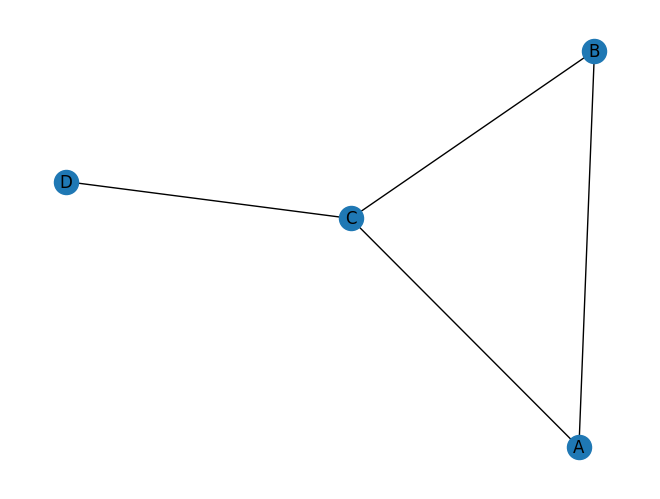

In [4]:
nx.draw(G, with_labels=True)

In [5]:
H = nx.Graph()
H.add_node('E')
H.add_node('F')
H.add_node('G')
H.add_node('H')
H.add_edge('E', 'F')
H.add_edge('F', 'G')
H.add_edge('G', 'H')

In [6]:
H.number_of_nodes(), H.number_of_edges()

(4, 3)

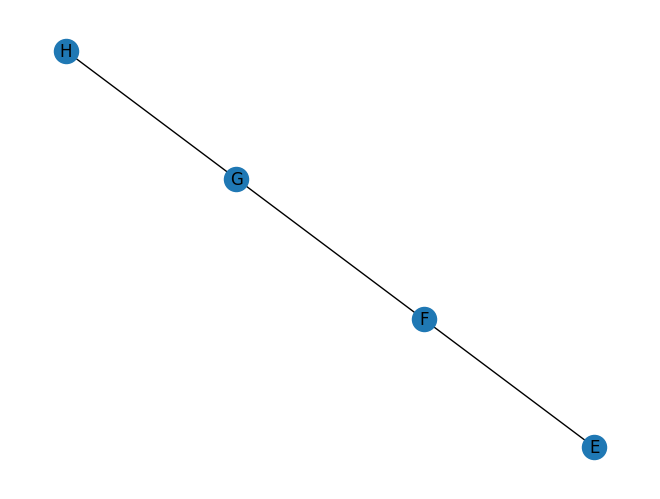

In [7]:
nx.draw(H, with_labels=True)

In [8]:
U = nx.cartesian_product(G, H)

In [9]:
U.number_of_nodes(), U.number_of_edges()

(16, 28)

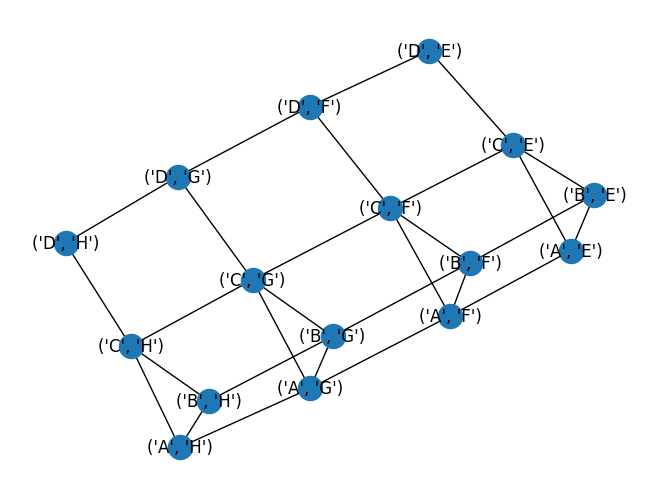

In [10]:
nx.draw(U, with_labels=True)

In [11]:
R = nx.full_join(G, H)

In [12]:
R.number_of_nodes(), R.number_of_edges()

(8, 23)

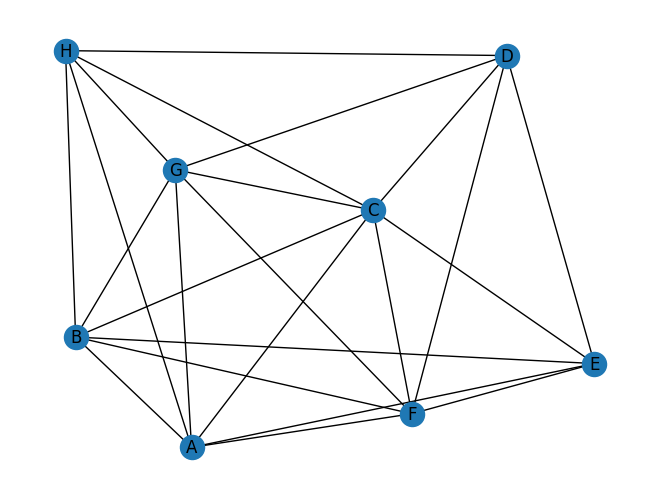

In [14]:
nx.draw(R, with_labels=True)

In [15]:
nx.adjacency_matrix(R).toarray()

array([[0, 1, 1, 0, 1, 1, 1, 1],
       [1, 0, 1, 0, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 1, 0],
       [1, 1, 1, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 0, 1, 0]])

In [16]:
R.edges()

EdgeView([('A', 'B'), ('A', 'C'), ('A', 'E'), ('A', 'F'), ('A', 'G'), ('A', 'H'), ('B', 'C'), ('B', 'E'), ('B', 'F'), ('B', 'G'), ('B', 'H'), ('C', 'D'), ('C', 'E'), ('C', 'F'), ('C', 'G'), ('C', 'H'), ('D', 'E'), ('D', 'F'), ('D', 'G'), ('D', 'H'), ('E', 'F'), ('F', 'G'), ('G', 'H')])

In [18]:
config = {'dataset':'ogbg-molesol'}

In [22]:
from itertools import combinations
from scipy.stats import rankdata, kendalltau

def sample_preference_pairs(graphs):
    c = [(a, b, check_util(graphs, a,b)) for a, b in combinations(range(len(graphs)), 2)]
    return np.array(c)

def check_util(data, index_a, index_b):
    a = data[index_a]
    b = data[index_b]
    util_a = a.y
    util_b = b.y
    if util_a >= util_b:
        return 1
    else:
        return 0

def rank_data(items):
    return rankdata(items, method='dense')

def compare_rankings_with_kendalltau(ranking_a, ranking_b):
    return kendalltau(ranking_a, ranking_b)

In [23]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.datasets import TUDataset
import numpy as np

def _ogb_available_datasets():
    return ['ogbg-molesol', 'ogbg-molfreesolv', 'ogbg-mollipo']

def _tud_available_datasets():
    return ['aspirin', 'ZINC_full']

def _load_data(config):
    '''
    Loads a dataset from [TUDataset, OGB]
    '''
    name = config['dataset']
    if name in _ogb_available_datasets():
        dataset= PygGraphPropPredDataset(name=name)
        config['num_node_features'] = dataset.num_node_features
    # elif name in _tud_available_datasets():
    #     dataset = TUDataset(root='/dataset/'+name, name=name)
    #     if not hasattr(dataset, 'get_idx_split'):
    #         VALID_SPLIT = 0.8
    #         TEST_SPLIT = 0.1
    #         train_size = int(VALID_SPLIT * len(dataset))
    #         valid_size = int(TEST_SPLIT * len(dataset))
    #         test_size = len(dataset) - train_size - valid_size
    #         # Split the dataset
    #         train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
    else:
        raise ValueError(f'Dataset {name} unknown')

    return dataset, dataset.get_idx_split()

def get_data(config):
    dataset, split_idx = _load_data(config)
    # Split the dataset into training, validation, and test sets
    train_dataset = dataset[split_idx['train']]
    valid_dataset = dataset[split_idx['valid']]
    test_dataset = dataset[split_idx['test']]

    # create pairs and targets
    train_prefs = sample_preference_pairs(train_dataset)
    valid_prefs = sample_preference_pairs(valid_dataset)
    _tmp = range(len(test_dataset))
    test_prefs = np.array(list(zip(_tmp, _tmp, _tmp))) # differs due to only needed for prediction
    test_ranking = rank_data([g.y.item() for g in test_dataset])
    return train_dataset, valid_dataset, test_dataset, train_prefs, valid_prefs, test_prefs, test_ranking

In [24]:
train_dataset, valid_dataset, test_dataset, train_prefs, valid_prefs, test_prefs, test_ranking = get_data(config)

In [26]:
test_dataset

PygGraphPropPredDataset(113)

In [45]:
g_a = test_dataset[3]
g_b = test_dataset[111]

In [46]:
print(g_a)
print(g_b)

Data(edge_index=[2, 10], edge_attr=[10, 3], x=[5, 9], y=[1, 1], num_nodes=5)
Data(edge_index=[2, 18], edge_attr=[18, 3], x=[9, 9], y=[1, 1], num_nodes=9)


In [43]:
nx_a = to_networkx(g_a)
nx_a.number_of_nodes(), nx_a.number_of_edges()

(5, 10)

In [44]:
nx.adjacency_matrix(nx_a).toarray()

array([[0, 1, 0, 0, 1],
       [1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0]])

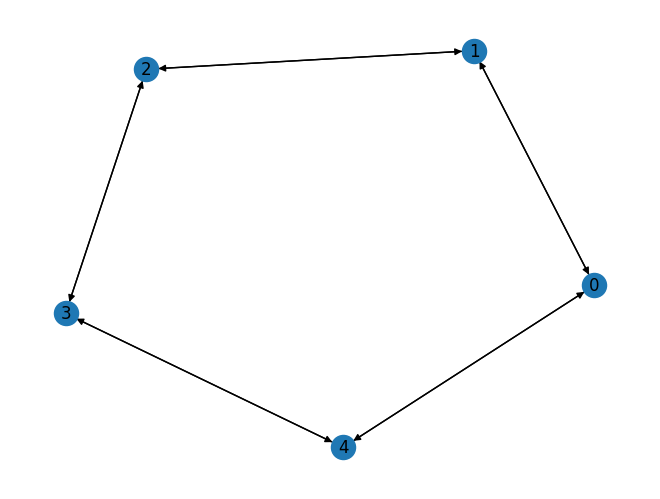

In [49]:
nx.draw(nx_a, with_labels=True)

In [47]:
nx_b = to_networkx(g_b)
nx_b.number_of_nodes(), nx_b.number_of_edges()

(9, 18)

In [48]:
nx.adjacency_matrix(nx_b).toarray()

array([[0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0]])

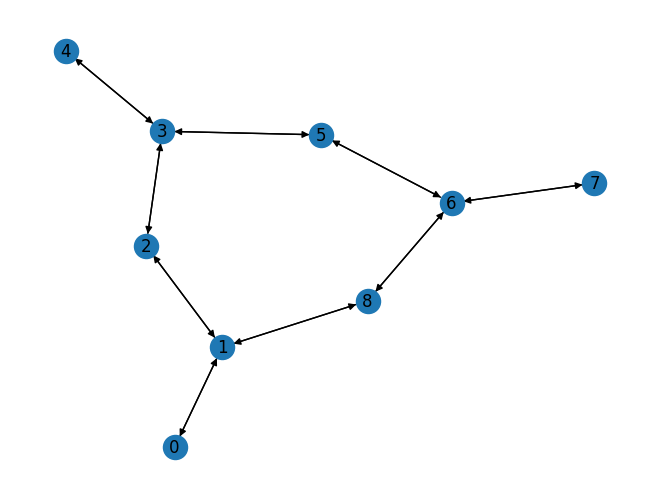

In [50]:
nx.draw(nx_b, with_labels=True)

In [87]:
g_b

Data(edge_index=[2, 18], edge_attr=[18, 3], x=[9, 9], y=[1, 1], num_nodes=9)

In [88]:
g_b.edge_attr

tensor([[0, 0, 0],
        [0, 0, 0],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [1, 0, 1],
        [1, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [1, 0, 1],
        [1, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1]])

In [90]:
g_b.x.numpy()

array([[ 5,  0,  4,  5,  3,  0,  2,  0,  0],
       [ 5,  0,  3,  5,  0,  0,  1,  1,  1],
       [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
       [ 5,  0,  3,  5,  0,  0,  1,  1,  1],
       [ 7,  0,  1,  5,  0,  0,  1,  0,  0],
       [ 6,  0,  3,  5,  1,  0,  1,  1,  1],
       [ 5,  0,  3,  5,  0,  0,  1,  1,  1],
       [15,  0,  1,  5,  0,  0,  1,  0,  0],
       [ 6,  0,  3,  5,  1,  0,  1,  1,  1]])

In [127]:
def convert_torch_to_nx(graph):
    print(f'convert_torch_to_nx():')
    # Convert torch_geometric graph to networkx graph
    nx_g = to_networkx(graph)
    
    # Extract edge attributes from torch_geometric graph
    edge_attrs = graph.edge_attr
    
    # Create a dictionary of edge attributes
    edge_attr_dict = {}
    for i, (u, v) in enumerate(nx_g.edges()):
        edge_attr_dict[(u, v)] = edge_attrs[i].tolist()  # Assuming edge_attr is a tensor
    
    # Set edge attributes
    nx.set_edge_attributes(nx_g, edge_attr_dict, 'edge_attr')
    
    # Extract node features from torch_geometric graph
    node_features = graph.x
    
    # Create a dictionary of node features
    node_attr_dict = {}
    for i, node in enumerate(nx_g.nodes()):
        node_attr_dict[node] = node_features[i].tolist()  # Assuming node features are tensors
    
    # Set node features
    nx.set_node_attributes(nx_g, node_attr_dict, 'x')

    print(f"Graph Node Features: {nx.get_node_attributes(nx_g, 'x')}")
    print(f"Graph Edge Attributes: {nx.get_edge_attributes(nx_g, 'edge_attr')}")
    
    return nx_g

In [128]:
nx_a = convert_torch_to_nx(g_a)

convert_torch_to_nx():
Graph Node Features: {0: [5, 0, 3, 5, 1, 0, 1, 1, 1], 1: [5, 0, 3, 5, 1, 0, 1, 1, 1], 2: [5, 0, 3, 5, 1, 0, 1, 1, 1], 3: [15, 0, 2, 5, 0, 0, 1, 1, 1], 4: [5, 0, 3, 5, 1, 0, 1, 1, 1]}
Graph Edge Attributes: {(0, 1): [3, 0, 1], (0, 4): [3, 0, 1], (1, 0): [3, 0, 1], (1, 2): [3, 0, 1], (2, 1): [3, 0, 1], (2, 3): [3, 0, 1], (3, 2): [3, 0, 1], (3, 4): [3, 0, 1], (4, 3): [3, 0, 1], (4, 0): [3, 0, 1]}


In [115]:
g_a.edge_attr

tensor([[3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1],
        [3, 0, 1]])

In [129]:
nx.get_edge_attributes(nx_a, 'edge_attr')

{(0, 1): [3, 0, 1],
 (0, 4): [3, 0, 1],
 (1, 0): [3, 0, 1],
 (1, 2): [3, 0, 1],
 (2, 1): [3, 0, 1],
 (2, 3): [3, 0, 1],
 (3, 2): [3, 0, 1],
 (3, 4): [3, 0, 1],
 (4, 3): [3, 0, 1],
 (4, 0): [3, 0, 1]}

In [117]:
g_a.x

tensor([[ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [15,  0,  2,  5,  0,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1]])

In [131]:
nx.get_node_attributes(nx_a, 'x')

{0: [5, 0, 3, 5, 1, 0, 1, 1, 1],
 1: [5, 0, 3, 5, 1, 0, 1, 1, 1],
 2: [5, 0, 3, 5, 1, 0, 1, 1, 1],
 3: [15, 0, 2, 5, 0, 0, 1, 1, 1],
 4: [5, 0, 3, 5, 1, 0, 1, 1, 1]}

In [178]:
def combine_two_graphs(graph_a, graph_b):
    # TODO: a) Kanten Beschriften, ob "standard" oder "Combiniation"      [__]
    # TODO: b) Welchen Wert bekommt der Graph                                       [✓]
    ''''
    Combines two Graphs into one
    Visualisation in Eigenanteil.ipynb
    '''
    nx_graph_a = convert_torch_to_nx(graph_a)
    nx_graph_b = convert_torch_to_nx(graph_b)
    temp_graph = nx.full_join(nx_graph_a, nx_graph_b, rename=("G", "H"))



    
    # Ensure all edges have the same attributes
    default_attrs = {'edge_attr': [0,0,0]}  # Default value for missing attributes
    for u, v in temp_graph.edges():
        for attr in default_attrs:
            if attr not in temp_graph[u][v]:
                temp_graph[u][v][attr] = default_attrs[attr]



                
    print(temp_graph)
    print(temp_graph.number_of_nodes(), temp_graph.number_of_edges())
    print(nx.adjacency_matrix(temp_graph).toarray())
    print(nx.get_edge_attributes(temp_graph, 'edge_attr'))
    print(nx.get_node_attributes(temp_graph, 'x'))
    temp_y = 1 if graph_a.y.item() >= graph_b.y.item() else 0
    print(temp_y)
    graph = from_networkx(temp_graph)
    graph.y = temp_y
    graph.num_nodes = graph_a.num_nodes + graph_b.num_nodes
    print(graph)
    print(graph.y)
    return graph

In [179]:
z=combine_two_graphs(g_b, g_a)
z.x

convert_torch_to_nx():
Graph Node Features: {0: [5, 0, 4, 5, 3, 0, 2, 0, 0], 1: [5, 0, 3, 5, 0, 0, 1, 1, 1], 2: [5, 0, 3, 5, 1, 0, 1, 1, 1], 3: [5, 0, 3, 5, 0, 0, 1, 1, 1], 4: [7, 0, 1, 5, 0, 0, 1, 0, 0], 5: [6, 0, 3, 5, 1, 0, 1, 1, 1], 6: [5, 0, 3, 5, 0, 0, 1, 1, 1], 7: [15, 0, 1, 5, 0, 0, 1, 0, 0], 8: [6, 0, 3, 5, 1, 0, 1, 1, 1]}
Graph Edge Attributes: {(0, 1): [0, 0, 0], (1, 0): [0, 0, 0], (1, 2): [3, 0, 1], (1, 8): [3, 0, 1], (2, 1): [3, 0, 1], (2, 3): [3, 0, 1], (3, 2): [1, 0, 1], (3, 4): [1, 0, 1], (3, 5): [3, 0, 1], (4, 3): [3, 0, 1], (5, 3): [3, 0, 1], (5, 6): [3, 0, 1], (6, 5): [1, 0, 1], (6, 7): [1, 0, 1], (6, 8): [3, 0, 1], (7, 6): [3, 0, 1], (8, 6): [3, 0, 1], (8, 1): [3, 0, 1]}
convert_torch_to_nx():
Graph Node Features: {0: [5, 0, 3, 5, 1, 0, 1, 1, 1], 1: [5, 0, 3, 5, 1, 0, 1, 1, 1], 2: [5, 0, 3, 5, 1, 0, 1, 1, 1], 3: [15, 0, 2, 5, 0, 0, 1, 1, 1], 4: [5, 0, 3, 5, 1, 0, 1, 1, 1]}
Graph Edge Attributes: {(0, 1): [3, 0, 1], (0, 4): [3, 0, 1], (1, 0): [3, 0, 1], (1, 2): [3, 0

tensor([[ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  3,  5,  0,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  1,  1],
        [ 7,  0,  1,  5,  0,  0,  1,  0,  0],
        [ 6,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  1,  1],
        [15,  0,  1,  5,  0,  0,  1,  0,  0],
        [ 6,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [15,  0,  2,  5,  0,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1]])

In [180]:
z.edge_attr

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [3, 0, 1],
        [3, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [3, 0, 1],
        [3, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 1],
        [1, 0, 1],
        [3, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [3, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [3, 0, 1],
        [3, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 1],
        [1, 0, 1],
        [3, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [3, 0, 1],
        [0, 0, 0],
        [0, 

In [174]:
g_a

Data(edge_index=[2, 10], edge_attr=[10, 3], x=[5, 9], y=[1, 1], num_nodes=5)

In [148]:
nx_z = to_networkx(z)

In [149]:
nx_z

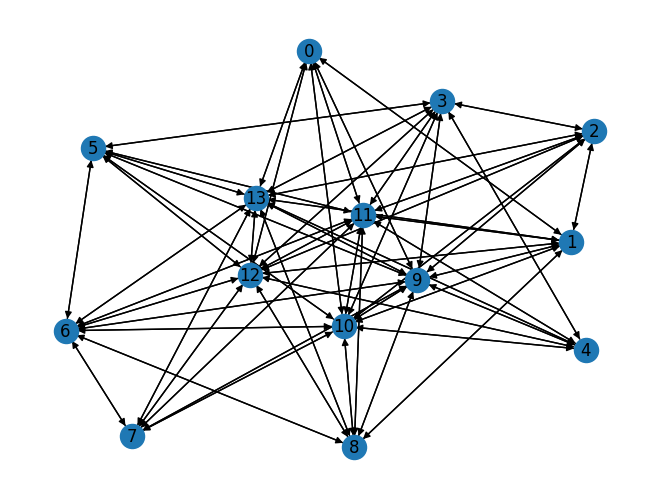

In [151]:
nx.draw(nx_z, with_labels=True)

In [152]:
nx.adjacency_matrix(nx_z).toarray()

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0]])

In [110]:
g_a.x

tensor([[ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1],
        [15,  0,  2,  5,  0,  0,  1,  1,  1],
        [ 5,  0,  3,  5,  1,  0,  1,  1,  1]])

In [111]:
nx.get_node_attributes(nx_a, 'node_features')

{0: [5, 0, 3, 5, 1, 0, 1, 1, 1],
 1: [5, 0, 3, 5, 1, 0, 1, 1, 1],
 2: [5, 0, 3, 5, 1, 0, 1, 1, 1],
 3: [15, 0, 2, 5, 0, 0, 1, 1, 1],
 4: [5, 0, 3, 5, 1, 0, 1, 1, 1]}

In [97]:
H = G.to_undirected()

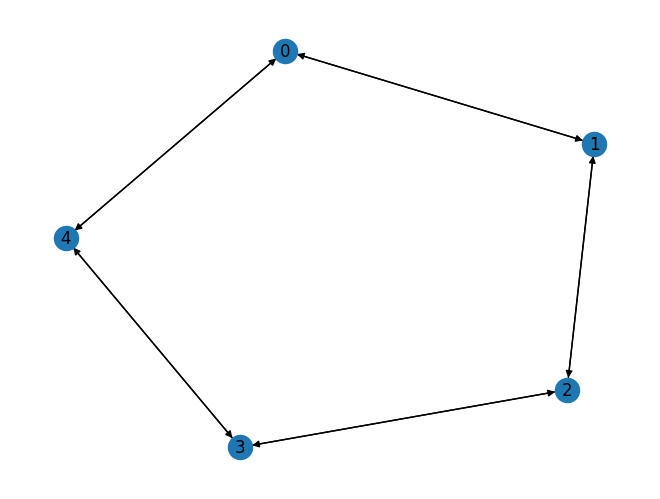

In [155]:
nx.draw(G, with_labels=True)

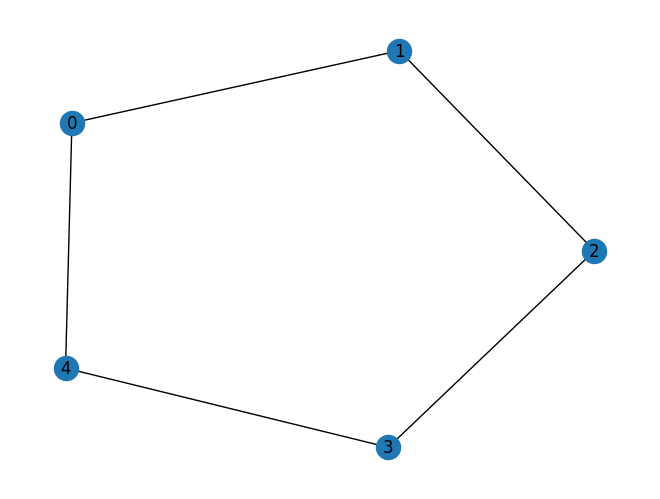

In [112]:
nx.draw(H, with_labels=True)

In [165]:
G = nx.DiGraph()
G.add_edge(1, 2, weight=4.2)
G.add_edge(2, 3, weight=3.1)

G.graph['new_attribute'] = 'example_value'

In [167]:
G.graph

{'new_attribute': 'example_value'}